<a href="https://colab.research.google.com/github/sexymetra/Ai-project/blob/LeeSangHyuck/%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%8B%9D%20%EC%85%8B%2C%20plt%EC%B6%94%EA%B0%80%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 베이스라인은 참고용 코드 입니다. 여러분 만의 고도화된 모델을 만들어 주세요

## Import

In [117]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#하이퍼 파라미터
CFG = {
    'EPOCHS':30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE' : 128
}


### 데이터 불러오기

In [37]:
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv("/content/drive/MyDrive/data/data/train_data.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/data/data/sample_submission.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 검사하기
각각의 결측치들을 맞게 바꿈
filter1 전력이 0 일때는 풍속이 2.5이상일 수 없다. -> 
전력이 0이고 풍속이 2.5이상일때, 다 풍속 0 으로 바꿨음


In [38]:
#각각의 결측치들을 맞게 바꿈
#filter1 전력이 0 일때는 풍속이 2.5이상일 수 없다. -> 전력이 0이고 풍속이 2.5이상일때, 다 풍속 0 으로 바꿨음
#filter1 = (train_data['Patv']<=0) & (train_data['Wspd']>2.5)
#train_data['Wspd'][filter1] = 0

#filter2 Pab1,2,3은 각각 89를 초과하면 안된다. -> Pab를 0으로 만들면 안될 것 같아서 NAN으로 만들고 있다가 보간해주기
#filter2 = (train_data['Pab1']>89)|(train_data['Pab2']>89)|(train_data['Pab3']>89)
#train_data['Pab1'][filter2] = np.NAN
#train_data['Pab2'][filter2] = np.NAN
#train_data['Pab3'][filter2] = np.NAN

#filter3 Ndir은 720을 초과하거나 -720보다 작아지면 안된다. 결측값이 별로 없으니까 720으로 나눈 나머지로 해도 될듯
#filter3 = (train_data['Ndir']>720)|(train_data['Ndir']<-720)
#train_data['Ndir'][filter3] = train_data['Ndir'][filter3]%720

#filter4 Wdir도 마찬가지
#filter4 = (train_data['Wdir']>180)|(train_data['Wdir']<-180)
#train_data['Wdir'][filter4] = train_data['Wdir'][filter4]%180


### 데이터 전처리

In [39]:
#결측치 0으로 만들기
train_data = train_data.fillna(0)

#3번째에 결측치를 평균으로 만들어 봄
#결측치 평균으로 만들기
#train_data = train_data.interpolate(method = 'linear')
#train_data = train_data.fillna(0)
#Pab1,2,3정리
train_data['Pab'] = train_data.loc[:,'Pab1':'Pab3'].median(axis=1) #Pad1,2,3의 중앙값으로 Pad설정
train_data.drop(train_data.loc[:,'Pab1':'Pab3'],axis=1,inplace = True) #Pad1,2,3 삭제
train_data = train_data.reindex(columns = ['TurbID','Day','Tmstamp','Wspd','Wdir','Etmp','Itmp','Ndir','Pab','Prtv','Patv']) #원래 순서로 행 정렬



In [40]:
def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 201 - 6):
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

In [41]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) + 1)

train_x, train_y = make_train_data(train_data)

100%|██████████| 134/134 [00:49<00:00,  2.71it/s]


In [42]:
train_x = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

In [43]:
train_x.shape, train_y.shape

((25996, 720, 9), (25996, 288))

Validation_set 나누기

In [ ]:
import sklearn

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=100)




In [54]:
X_train.shape

(20796, 720, 9)

In [56]:
Y_train.shape

(20796, 288)

In [55]:
X_test.shape

(5200, 720, 9)

In [57]:
Y_test.shape

(5200, 288)

### Custom Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [10]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

### 모델 선언

In [118]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.gru = nn.GRU(input_size=9, hidden_size=256, batch_first=True,dropout=0.3,bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(256,516),
            nn.ReLU(),
            nn.Linear(516,288),
            nn.ReLU()
        )
        
    def forward(self, x):
        hidden, _ = self.gru(x)
        output = self.classifier(hidden[:,-1,:])
        return output

### 모델 학습

In [119]:
def train(model, optimizer, train_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    metric = nn.L1Loss().to(device)#이게 L1Loss였는데 MSE로 바꿈 첫번째 버전 -> 두번째 버전
    best_mae = 9999999
    global L_L
    L_L=[]
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            with torch.no_grad():
                mae = metric(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            train_mae.append(mae.item())
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Train MAE : [{np.mean(train_mae):.5f}]')
        
        L_L.append(np.mean(train_loss))

        if best_mae > np.mean(train_mae):
            best_mae = np.mean(train_mae)
            torch.save(model.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
            print('Model Saved.')

In [120]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
train(model, optimizer, train_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 204/204 [00:15<00:00, 13.06it/s]


Epoch : [1] Train Loss : [192886.26639] Train MAE : [331.86709]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 13.28it/s]


Epoch : [2] Train Loss : [161412.63151] Train MAE : [315.53376]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 13.17it/s]


Epoch : [3] Train Loss : [148330.03776] Train MAE : [299.53452]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 13.09it/s]


Epoch : [4] Train Loss : [135328.53646] Train MAE : [282.56157]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 13.03it/s]


Epoch : [5] Train Loss : [127806.45121] Train MAE : [272.14067]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 12.93it/s]


Epoch : [6] Train Loss : [122090.41900] Train MAE : [264.50179]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 12.79it/s]


Epoch : [7] Train Loss : [118627.03841] Train MAE : [259.64620]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 12.83it/s]


Epoch : [8] Train Loss : [114580.11769] Train MAE : [254.26006]
Model Saved.


100%|██████████| 204/204 [00:15<00:00, 12.83it/s]


Epoch : [9] Train Loss : [111421.52397] Train MAE : [249.98101]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.72it/s]


Epoch : [10] Train Loss : [107567.72469] Train MAE : [244.48552]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.40it/s]


Epoch : [11] Train Loss : [104333.04059] Train MAE : [239.81837]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.38it/s]


Epoch : [12] Train Loss : [100479.24383] Train MAE : [234.40726]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.35it/s]


Epoch : [13] Train Loss : [96826.39480] Train MAE : [229.14531]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.37it/s]


Epoch : [14] Train Loss : [93100.37420] Train MAE : [223.30648]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.34it/s]


Epoch : [15] Train Loss : [89635.44053] Train MAE : [218.22109]
Model Saved.


100%|██████████| 204/204 [00:16<00:00, 12.38it/s]


Epoch : [16] Train Loss : [85821.15916] Train MAE : [212.37130]
Model Saved.


 35%|███▍      | 71/204 [00:05<00:10, 12.25it/s]


KeyboardInterrupt: ignored

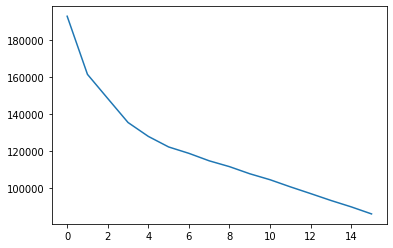

In [121]:
import matplotlib.pyplot as plt

plt.plot(L_L)

### 201일, 202일 Patv 추론

In [81]:
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])

In [82]:
test_data.shape

(134, 720, 9)

In [83]:
test_dataset = CustomDataset(test_data, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [84]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

### Model Load

In [85]:
model = BaseModel()
best_checkpoint = torch.load('./best_model.pth')
model.load_state_dict(best_checkpoint)
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BaseModel(
  (gru): GRU(9, 256, batch_first=True, dropout=0.3)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=516, bias=True)
    (1): ReLU()
    (2): Linear(in_features=516, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [86]:
preds = predict(model, test_loader, device)
preds = preds.reshape(-1)

100%|██████████| 2/2 [00:00<00:00, 25.68it/s]


### Submit

In [87]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)

In [88]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,0,0,0,0,0,0,0,0,0,178.602203
1,1,1,201,00:10,0,0,0,0,0,0,0,0,0,206.661453
2,2,1,201,00:20,0,0,0,0,0,0,0,0,0,195.783203
3,3,1,201,00:30,0,0,0,0,0,0,0,0,0,200.451508
4,4,1,201,00:40,0,0,0,0,0,0,0,0,0,208.227264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,0,0,0,0,0,0,0,0,0,149.495407
38588,38588,134,202,23:20,0,0,0,0,0,0,0,0,0,148.400696
38589,38589,134,202,23:30,0,0,0,0,0,0,0,0,0,141.977905
38590,38590,134,202,23:40,0,0,0,0,0,0,0,0,0,157.154999


In [89]:
sample_submission['Patv'].describe()

count    38592.000000
mean       213.369578
std        108.022921
min          0.000000
25%        138.374268
50%        213.338028
75%        281.003136
max        736.466980
Name: Patv, dtype: float64

In [90]:
train_data['Patv'].describe()

count    3.859200e+06
mean     3.547038e+02
std      4.252410e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.856800e+02
75%      5.579225e+02
max      1.567020e+03
Name: Patv, dtype: float64

In [91]:
train_data['Patv'].tail(288)

3858912    1351.26
3858913    1241.45
3858914    1511.15
3858915    1517.90
3858916    1518.11
            ...   
3859195     308.65
3859196     221.60
3859197     220.60
3859198     222.15
3859199     264.17
Name: Patv, Length: 288, dtype: float64